# Basics

to start, let's import a few things we'll need:

In [1]:
# other package imports
import json

import matplotlib.pyplot as plt  # keep this import for CI to work
from zanj import ZANJ  # saving/loading data

# maze_dataset imports
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze
from maze_dataset.dataset.configs import MAZE_DATASET_CONFIGS
from maze_dataset.generation import GENERATORS_MAP, LatticeMazeGenerators
from maze_dataset.generation.default_generators import DEFAULT_GENERATORS
from maze_dataset.plotting import plot_dataset_mazes

# check the configs
print(MAZE_DATASET_CONFIGS.keys())
# for saving/loading things
LOCAL_DATA_PATH: str = "../data/maze_dataset/"
zanj: ZANJ = ZANJ(external_list_threshold=256)


def pprint_summary(summary: dict) -> None:
	"pretty print as json"
	print(json.dumps(summary, indent=2))

['test-g3-n5-a_dfs-h92479', 'test-perc-g3-n5-a_dfs_percolation-h28992', 'demo_small-g3-n100-a_dfs-h82886', 'demo-g6-n10K-a_dfs-h66925']


You should always see `test-g3-n5-a_dfs-h92479` in the list of available dataset configs above.

Now, let's set up our initial config and dataset:

In [2]:
cfg: MazeDatasetConfig = MazeDatasetConfig(
	name="test",  # name is only for you to keep track of things
	grid_n=5,  # number of rows/columns in the lattice
	n_mazes=4,  # number of mazes to generate
	maze_ctor=LatticeMazeGenerators.gen_dfs,  # algorithm to generate the maze
	# there are a few more arguments here, to be discussed later
)

# each config will use this function to get the name of the dataset
# it contains some basic info about the algorithm, size, and number of mazes
# at the end after "h" is a stable hash of the config to avoid collisions
print(cfg.to_fname())

test-g5-n4-a_dfs-h51196


In [3]:
# to create a dataset, just call MazeDataset.from_config
dataset: MazeDataset = MazeDataset.from_config(
	# your config
	cfg,
	# and all this below is completely optional
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=True,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False,  # parallel generation has overhead, not worth it unless you're doing a lot of mazes
)

trying to get the dataset 'test-g5-n4-a_dfs-h51196'
generating dataset...


generating & solving mazes: 100%|██████████| 4/4 [00:00<00:00, 780.48maze/s]

saving dataset to ../data/maze_dataset/test-g5-n4-a_dfs-h51196.zanj
Got dataset test with 4 items. output.cfg.to_fname() = 'test-g5-n4-a_dfs-h51196'


now that we have our dataset, let's take a look at it!

(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

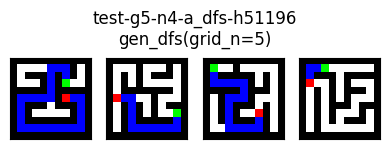

In [4]:
plot_dataset_mazes(
	dataset,
	count=None,
)  # for large datasets, set the count to some int to just plot the first few

# Filtering

you can also filter datasets by a variety of parameters:

In [5]:
dataset_filtered: MazeDataset = dataset.filter_by.path_length(min_length=3)

print(f"{len(dataset) = }")
print(f"{len(dataset_filtered) = }")

len(dataset) = 4
len(dataset_filtered) = 4


(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

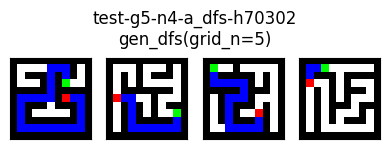

In [6]:
plot_dataset_mazes(dataset_filtered)

In [7]:
pprint_summary(dataset_filtered.cfg.serialize()["applied_filters"])
print(f"{MazeDataset._FILTER_NAMESPACE = }")

[
  {
    "name": "path_length",
    "args": [],
    "kwargs": {
      "min_length": 3
    }
  }
]
MazeDataset._FILTER_NAMESPACE = <class 'maze_dataset.dataset.filters.MazeDatasetFilters'>


In [8]:
# filters can also be specified at generation time -- but it will still generate the whole dataset and then filter it

dataset_filtered_from_scratch: MazeDataset = MazeDataset.from_config(
	dataset_filtered.cfg,
	do_download=False,
	load_local=False,
	do_generate=True,
	save_local=False,
	local_base_path=LOCAL_DATA_PATH,
	verbose=True,
	zanj=zanj,
	gen_parallel=False,
)

trying to get the dataset 'test-g5-n4-a_dfs-h70302'
generating dataset...


generating & solving mazes: 100%|██████████| 4/4 [00:00<00:00, 669.72maze/s]

Got dataset test with 4 items. output.cfg.to_fname() = 'test-g5-n4-a_dfs-h70302'


(<Figure size 400x200 with 4 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

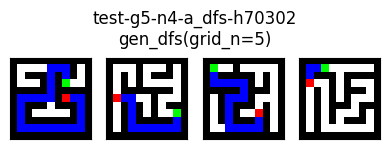

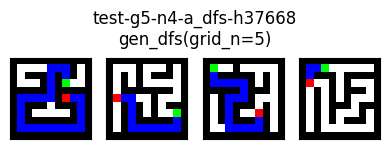

In [9]:
plot_dataset_mazes(dataset_filtered_from_scratch)
dataset_filtered_nodupe = dataset_filtered_from_scratch.filter_by.remove_duplicates()
plot_dataset_mazes(dataset_filtered_nodupe)

No mazes to plot for dataset


/home/miv/projects/mazes/maze-dataset/maze_dataset/dataset/maze_dataset.py:544: UserWarning: updating config n_mazes from 4 to 0
  warnings.warn(


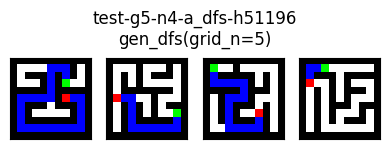

In [10]:
dataset_filtered_custom: MazeDataset = dataset.custom_maze_filter(
	lambda m, p: len(m.solution) == p,
	p=5,
)
plot_dataset_mazes(dataset)
plot_dataset_mazes(dataset_filtered_custom)

## metadata

by default, each maze stores some metadata about generation in a dictionary. if you don't care about this, you can filter it out (but keep some statistics) to save on storage space:

In [11]:
dataset_with_meta = dataset.filter_by.collect_generation_meta()
metadata = dataset_with_meta.serialize()["generation_metadata_collected"]
metadata["visited_cells"] = "..."  # this is a huge list and unweildy to print
pprint_summary(metadata)

{
  "func_name": {
    "gen_dfs": 4
  },
  "grid_shape": {
    "(np.int64(5), np.int64(5))": 4
  },
  "start_coord": {
    "(np.int64(2), np.int64(3))": 1,
    "(np.int64(0), np.int64(3))": 1,
    "(np.int64(0), np.int64(1))": 1,
    "(np.int64(1), np.int64(3))": 1
  },
  "n_accessible_cells": {
    "25": 4
  },
  "max_tree_depth": {
    "50": 4
  },
  "fully_connected": {
    "True": 4
  },
  "visited_cells": "..."
}


# output formats

ASCII:

###########
#    XXX# #
# ###X#X# #
#   #X#S  #
#####X#####
#XXXXX#EXX#
#X### ###X#
#X#     #X#
#X#######X#
#XXXXXXXXX#
###########


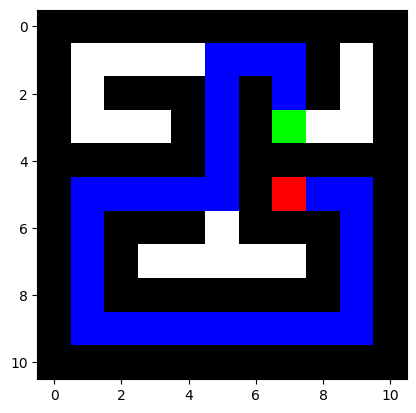

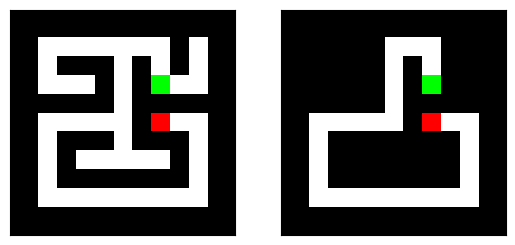


Raw tokens:

<ADJLIST_START> (0,0) <--> (1,0) ; (2,0) <--> (3,0) ; (4,1) <--> (4,0) ; (2,0) <--> (2,1) ; (1,0) <--> (1,1) ; (3,4) <--> (2,4) ; (4,2) <--> (4,3) ; (0,0) <--> (0,1) ; (0,3) <--> (0,2) ; (4,4) <--> (3,4) ; (4,3) <--> (4,4) ; (4,1) <--> (4,2) ; (2,1) <--> (2,2) ; (1,4) <--> (0,4) ; (1,2) <--> (0,2) ; (2,4) <--> (2,3) ; (4,0) <--> (3,0) ; (2,2) <--> (3,2) ; (1,2) <--> (2,2) ; (1,3) <--> (0,3) ; (3,2) <--> (3,3) ; (0,2) <--> (0,1) ; (3,1) <--> (3,2) ; (1,3) <--> (1,4) ; <ADJLIST_END> <ORIGIN_START> (1,3) <ORIGIN_END> <TARGET_START> (2,3) <TARGET_END> <PATH_START> (1,3) (0,3) (0,2) (1,2) (2,2) (2,1) (2,0) (3,0) (4,0) (4,1) (4,2) (4,3) (4,4) (3,4) (2,4) (2,3) <PATH_END>

Colored tokens, raw html:

<span style="color: black; background-color: rgb(176,152,232)">&nbsp&lt;ADJLIST_START&gt; (0,0) &lt;--&gt; (1,0) ; (2,0) &lt;--&gt; (3,0) ; (4,1) &lt;--&gt; (4,0) ; (2,0) &lt;--&gt; (2,1) ; (1,0) &lt;--&gt; (1,1) ; (3,4) &lt;--&gt; (2,4) ; (4,2) &lt;--&gt; (4,3) ; (0,0) &lt;--&gt; (0

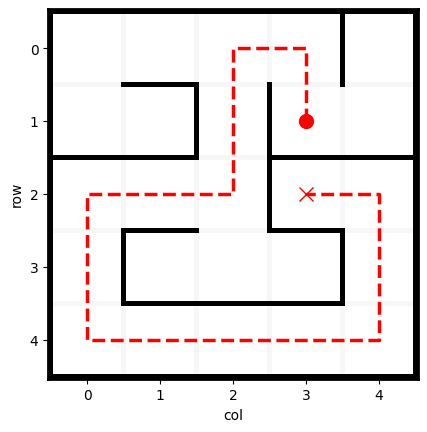

In [12]:
from maze_dataset.dataset.rasterized import process_maze_rasterized_input_target
from maze_dataset.plotting import MazePlot
from maze_dataset.plotting.print_tokens import (
	color_maze_tokens_AOTP,
	display_color_maze_tokens_AOTP,
)
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode

maze: SolvedMaze = dataset[0]

# as pixels (what you've already seen)
plt.imshow(maze.as_pixels())

# as ascii (useful for debugging)
print("ASCII:\n")
print(maze.as_ascii())

# as e2h style input/target
input_, target = process_maze_rasterized_input_target(maze)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(input_)
ax[1].imshow(target)
# remove ticks
for a in ax:
	a.set_xticks([])
	a.set_yticks([])
plt.show()


# as a MazePlot
MazePlot(maze).plot()

# as tokens

# first, initialize a tokenizer -- more about this in the `notebooks/demo_tokenization.ipynb` notebook
tokenizer: MazeTokenizer = MazeTokenizer(
	tokenization_mode=TokenizationMode.AOTP_UT_rasterized,
	max_grid_size=100,
)
maze_tok = maze.as_tokens(maze_tokenizer=tokenizer)

# you can view the tokens directly
print("\nRaw tokens:\n")
print(" ".join(maze_tok))

# or color and print them in various formats
print("\nColored tokens, raw html:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="html"))
print("\nColored tokens, raw latex:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="latex"))
print("\nColored tokens, terminal:\n")
print(color_maze_tokens_AOTP(maze_tok, fmt="terminal"))

display_color_maze_tokens_AOTP(maze_tok)

# endpoint options

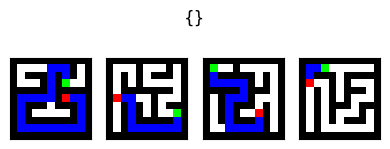

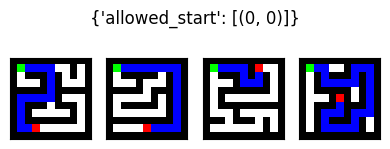

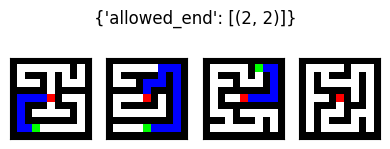

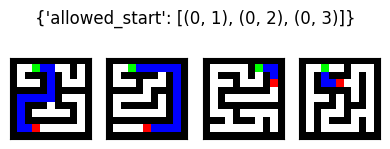

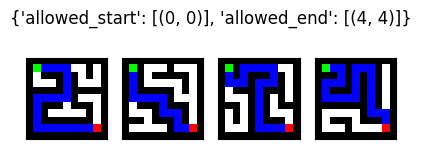

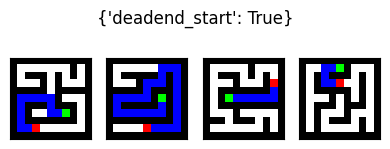

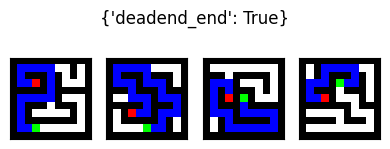

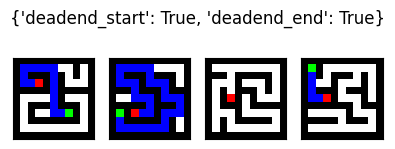

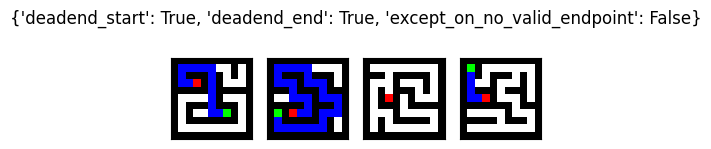

In [13]:
for endpoint_kwargs in [
	dict(),
	dict(allowed_start=[(0, 0)]),
	dict(allowed_end=[(2, 2)]),
	dict(allowed_start=[(0, 1), (0, 2), (0, 3)]),
	dict(allowed_start=[(0, 0)], allowed_end=[(4, 4)]),
	dict(deadend_start=True),
	dict(deadend_end=True),
	dict(deadend_start=True, deadend_end=True),
	dict(deadend_start=True, deadend_end=True, except_on_no_valid_endpoint=False),
]:
	d = MazeDataset.from_config(
		MazeDatasetConfig(
			name="endpoint-test",
			grid_n=5,
			n_mazes=4,
			maze_ctor=LatticeMazeGenerators.gen_dfs,
			endpoint_kwargs=endpoint_kwargs,
		),
	)

	plot_dataset_mazes(d, title=str(endpoint_kwargs))

(<Figure size 200x200 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

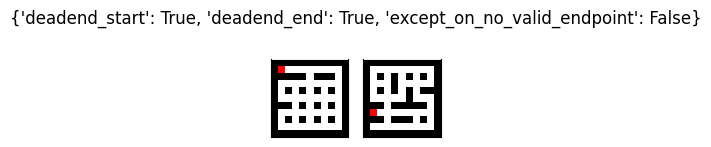

In [14]:
# endpoint options with percolation
d_endpt = MazeDataset.from_config(
	MazeDatasetConfig(
		name="endpoint-test",
		grid_n=5,
		n_mazes=4,
		maze_ctor=LatticeMazeGenerators.gen_dfs_percolation,
		maze_ctor_kwargs=dict(p=0.8),
		endpoint_kwargs=dict(
			deadend_start=True,
			deadend_end=True,
			except_on_no_valid_endpoint=False,
		),
	),
)

plot_dataset_mazes(d_endpt, title=str(endpoint_kwargs))

# more algorithms

there are a bunch of algorithms included, some with various parameters. Here's a few:

In [15]:
DATASETS: dict[int, list[MazeDataset]] = dict()
for grid_n in [4, 8]:
	DATASETS[grid_n] = list()
	for gen_name, gen_kwargs in DEFAULT_GENERATORS:
		print(f"Generating {gen_name} for grid_n={grid_n}")
		DATASETS[grid_n].append(
			MazeDataset.from_config(
				MazeDatasetConfig(
					name="demo",
					maze_ctor=GENERATORS_MAP[gen_name],
					grid_n=grid_n,
					n_mazes=8,
					maze_ctor_kwargs=gen_kwargs,
				),
				local_base_path=LOCAL_DATA_PATH,
				load_local=False,
				verbose=False,
				zanj=zanj,
			),
		)

Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_dfs for grid_n=4
Generating gen_wilson for grid_n=4
Generating gen_percolation for grid_n=4
Generating gen_dfs_percolation for grid_n=4
Generating gen_dfs_percolation for grid_n=4
Generating gen_kruskal for grid_n=4
Generating gen_recursive_division for grid_n=4
Generating gen_dfs for grid_n=8
Generating gen_dfs for grid_n=8
Generating gen_dfs for grid_n=8
Generating gen_dfs for grid_n=8
Generating gen_wilson for grid_n=8
Generating gen_percolation for grid_n=8
Generating gen_dfs_percolation for grid_n=8
Generating gen_dfs_percolation for grid_n=8
Generating gen_kruskal for grid_n=8
Generating gen_recursive_division for grid_n=8


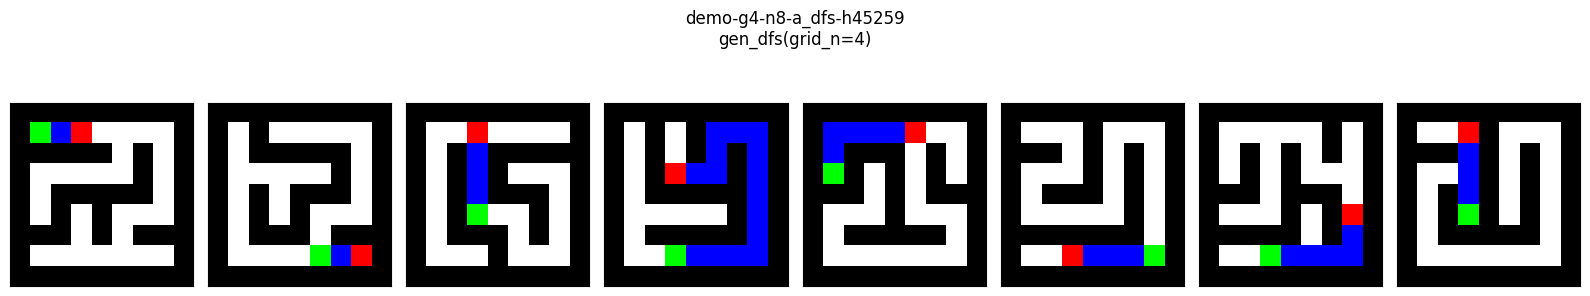

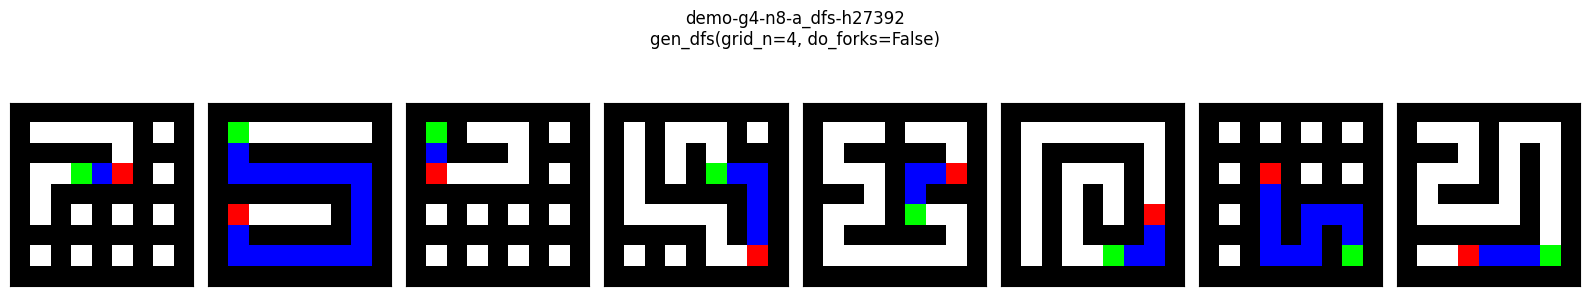

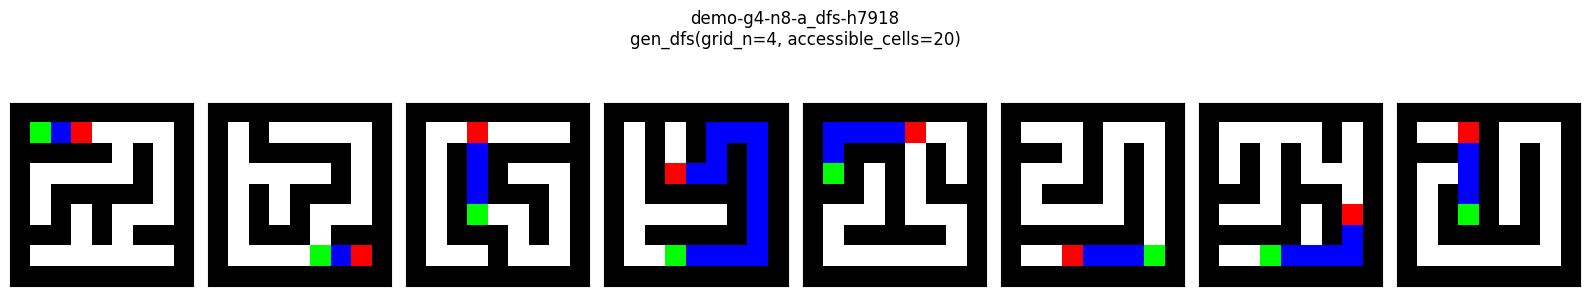

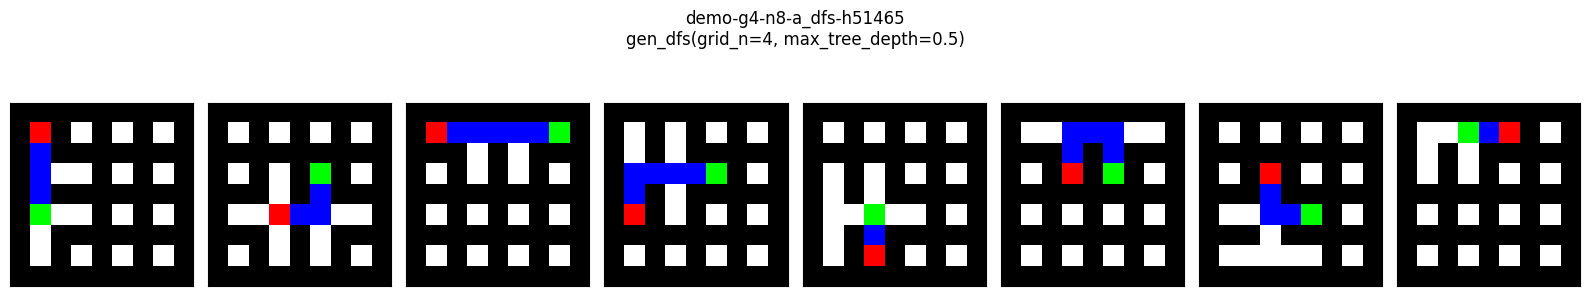

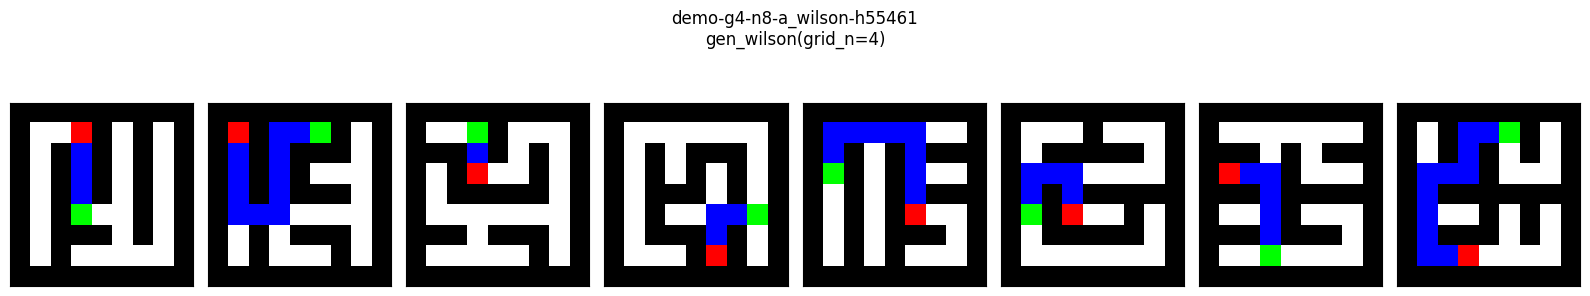

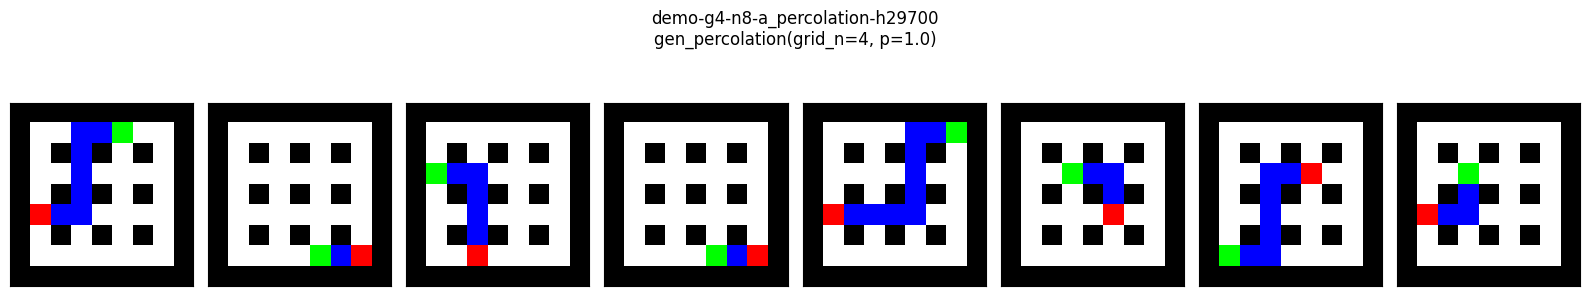

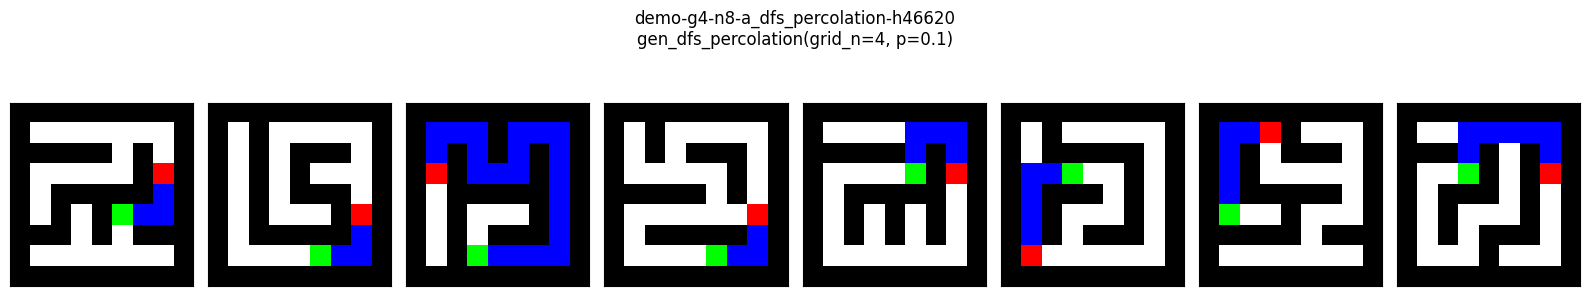

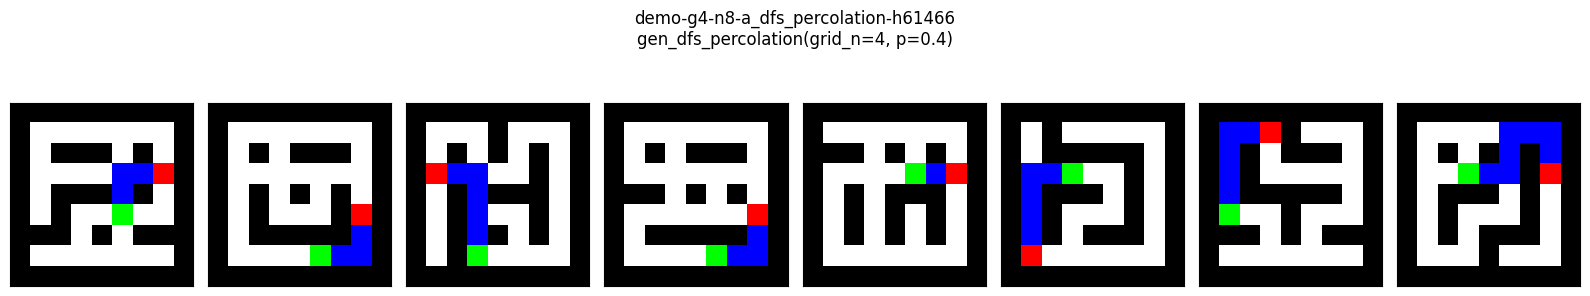

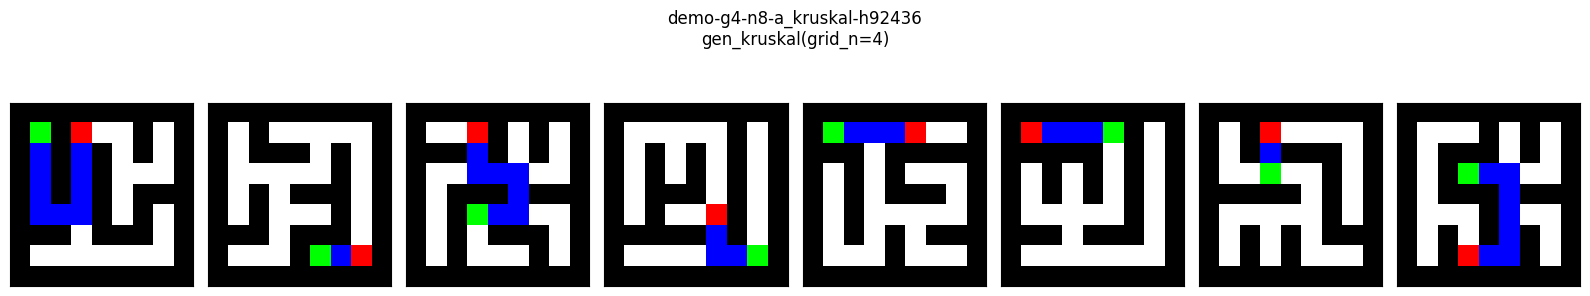

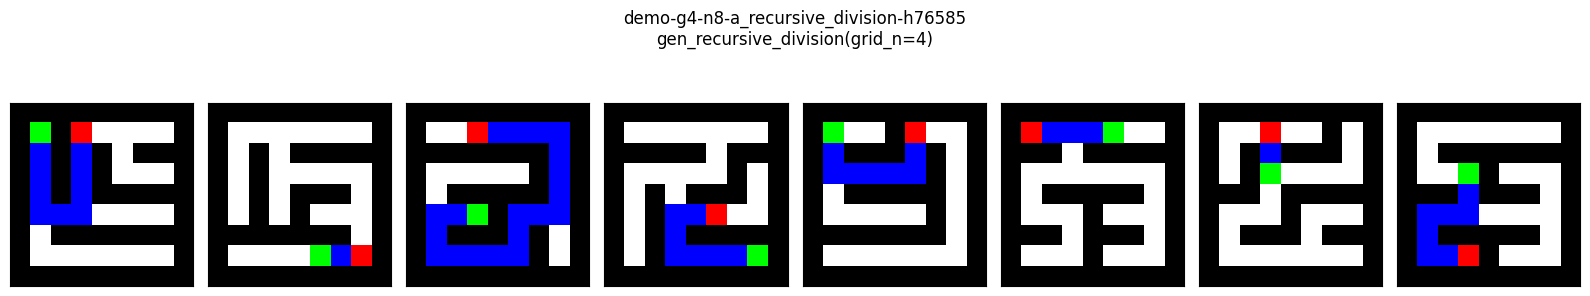

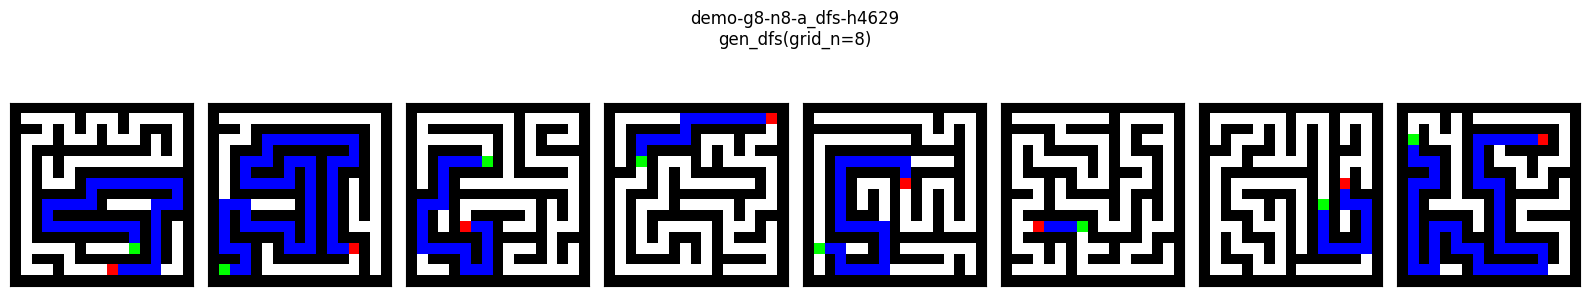

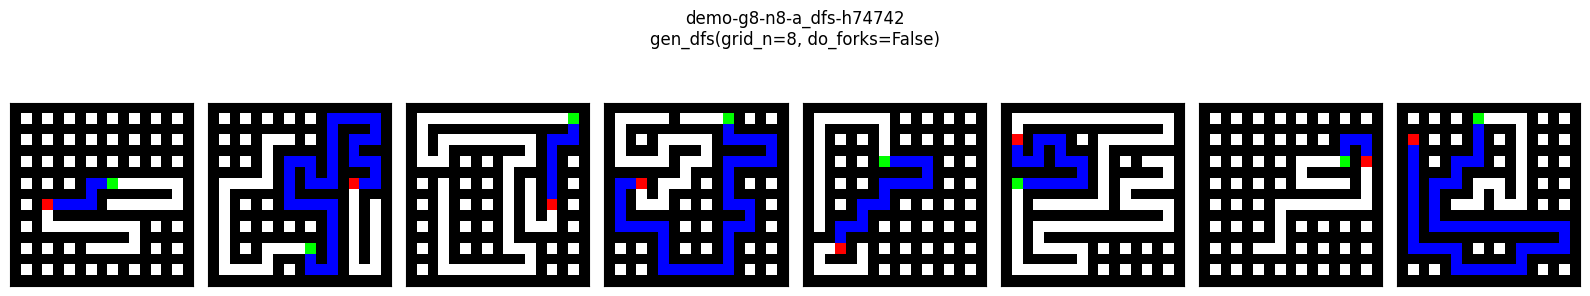

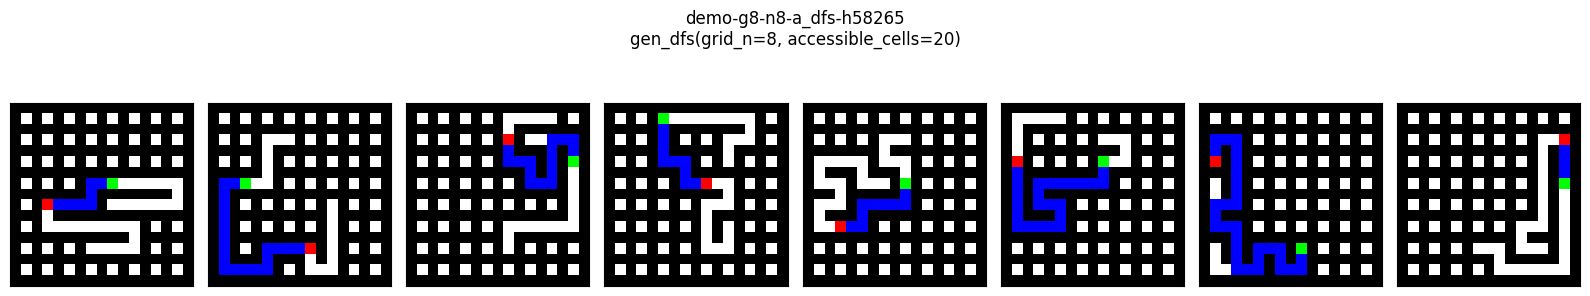

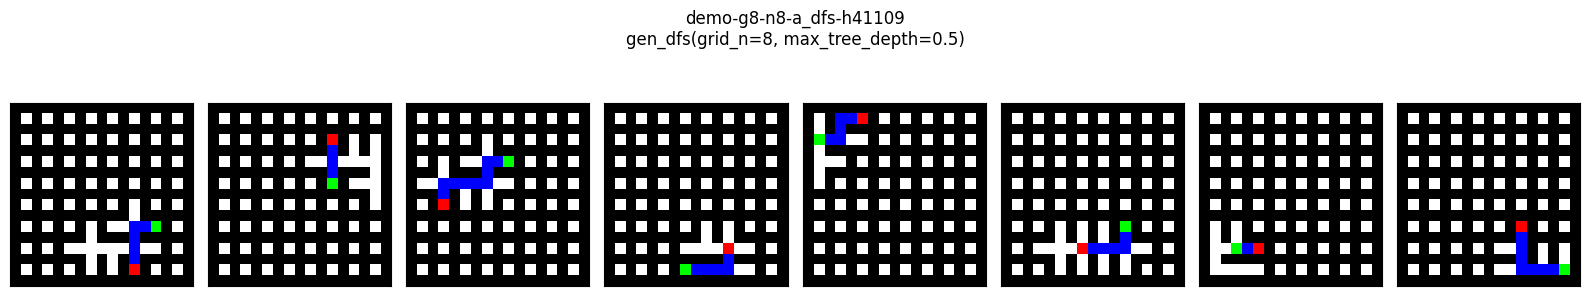

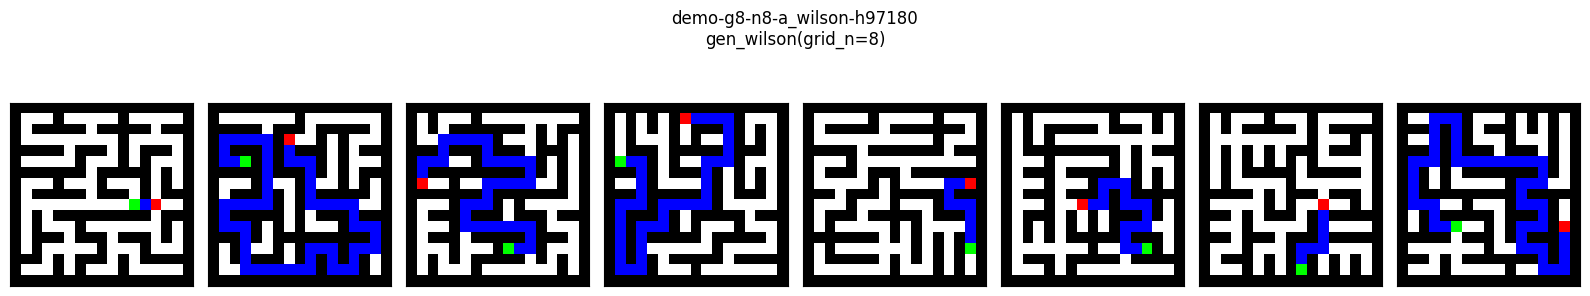

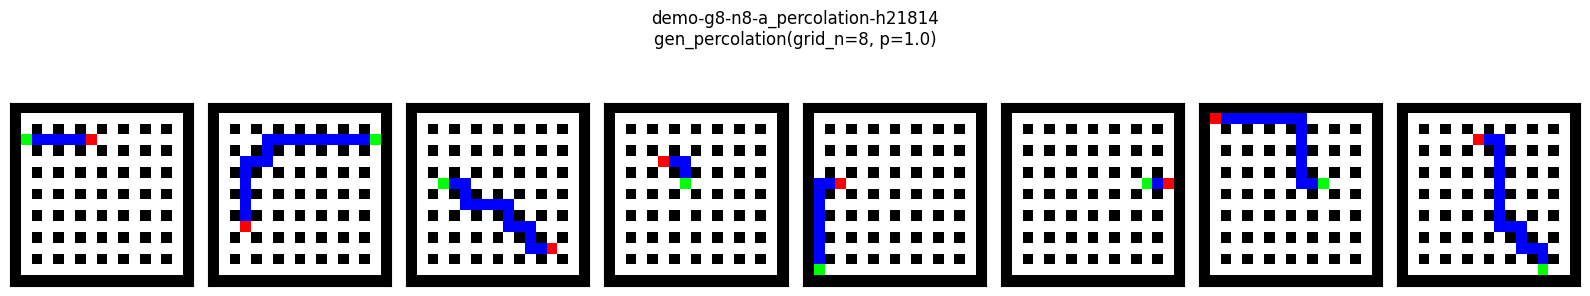

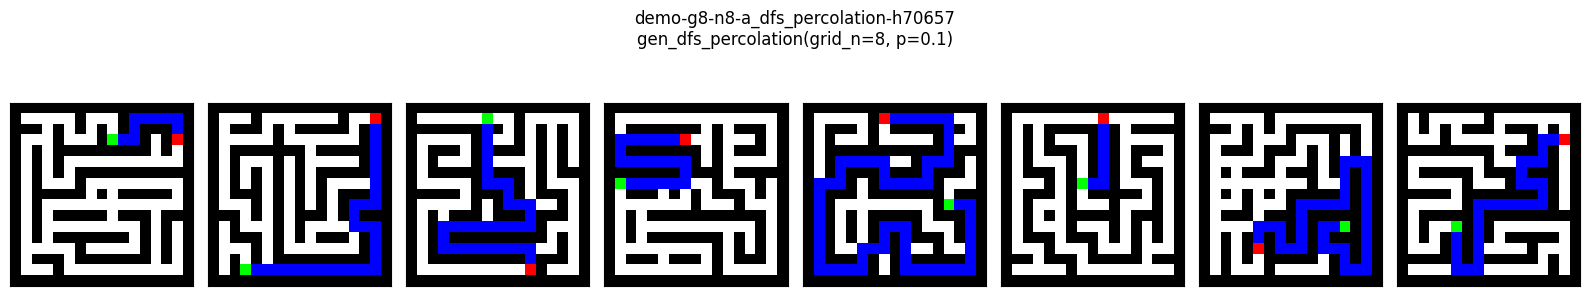

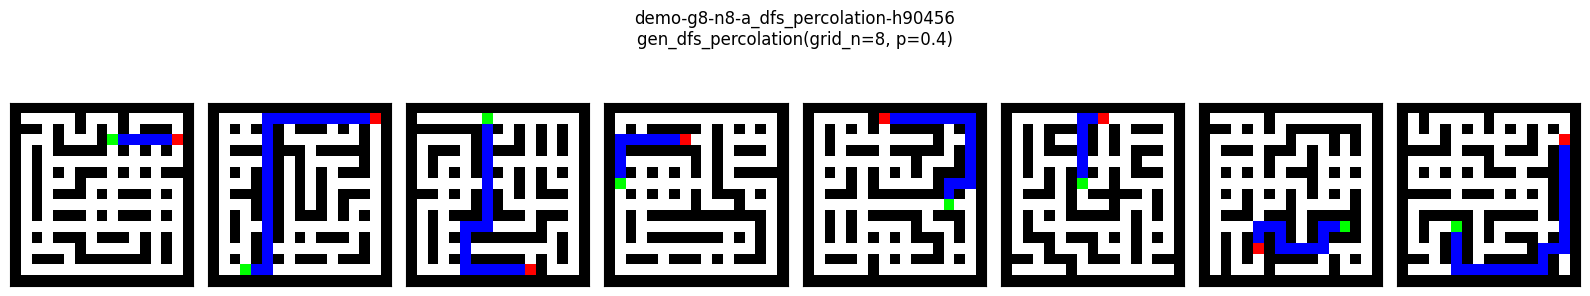

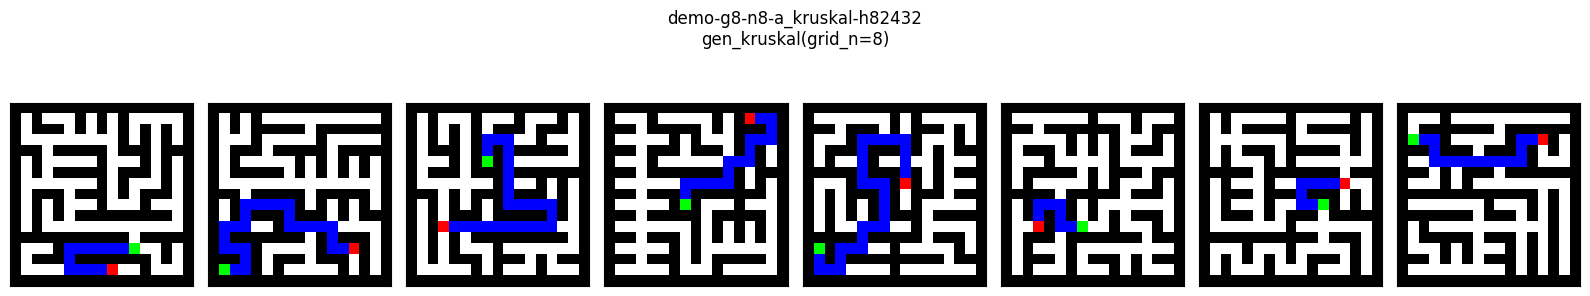

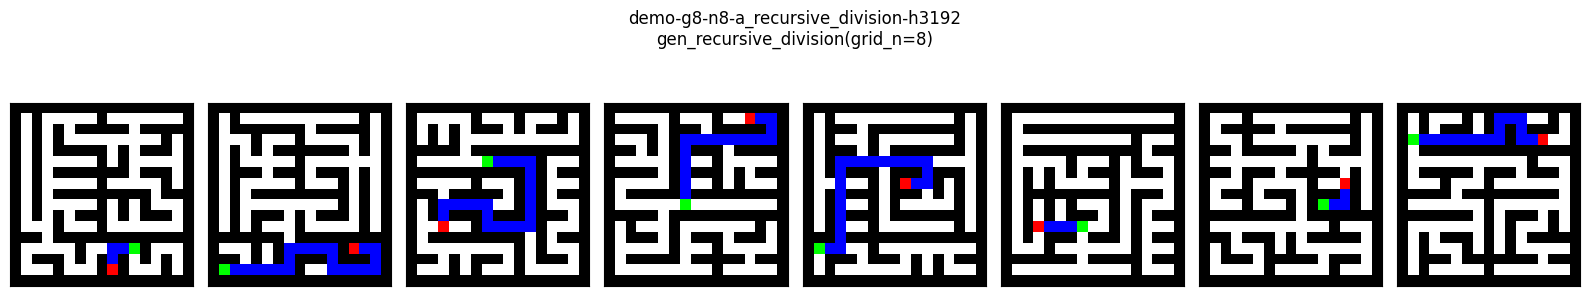

In [16]:
for ds_list in DATASETS.values():
	for ds in ds_list:
		plot_dataset_mazes(ds, figsize_mult=(2, 4))